The notebook zooms into the best optwrf simulation over New York State to figure out why some of the parameterizations performed well there.

Updated by Jeffrey Sward on November 3, 2020 

In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, geo_bounds)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

# Import the optwrf module
import optwrf
from optwrf import runwrf
from optwrf import helper_functions as hf
from optwrf import postwrf, plots

In [2]:
# # Define the path to where you WRF data file is stored 
# # (note: don't forget to add the "/" at the end of the directory)
# wrfout_dir = '/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/Wind Resource Analysis/wrfout/19mp4lw4sw7lsm8pbl99cu/'
# wrfout_file = 'wrfout_d01_2011-07-17'
# wrfout_file_processed = 'processed_' + wrfout_file

# # Process the WRF data
# process_data = False
# if process_data:
#     met_data = postwrf.process_wrfout_manual(wrfout_dir, wrfout_file, save_file=False)
# else:
#     met_data = xr.open_dataset(wrfout_dir+wrfout_file_processed)
# met_data

In [3]:
# Verbose setting
verbose = True

# Define the datestr, paramstr, and wrfout file names
datestr = '2011-12-13'
paramstr = '19mp4lw4sw7lsm8pbl99cu'
# paramstr = '8mp4lw4sw2lsm2pbl6cu'
wrffile_name = f'wrfout_processed_d01_{datestr}_{paramstr}.nc'
wrffile_name_orig = f'wrfout_d01_{datestr}_{paramstr}.nc'

# Find the absolute file path to your optwrf package
optwrf_abspath = os.path.dirname(os.path.abspath(inspect.getfile(optwrf)))
optwrf_abspath

# Specify the path to the processed wrfout file
wrfdir = os.path.join(optwrf_abspath, 'data/optwrf_sim/')
wrffile = os.path.join(wrfdir, wrffile_name)
wrfdata = xr.open_dataset(wrffile)
if verbose:
    print(f'Processeed WRF DATA:\n{wrfdata}\n')
    
# Open the processed ERA5 data
eradir = os.path.join(optwrf_abspath, 'data/')
erafile = os.path.join(eradir, 'ERA5_EastUS_WPD-GHI_2011-12.nc')
eradata = xr.open_dataset(erafile)
if verbose:
    print(f'ERA5 DATA:\n{eradata}')

Processeed WRF DATA:
<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 ...
    wind_speed10    (Time, south

In [4]:
# Get the map projection information for plotting
wrf_cartopy_proj = plots.get_wrf_proj(wrfdata, 'ghi')

In [5]:
wrfdata

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 ...
    wind_speed10    (Time, south_north, west_east) float32 ...
    wind_speed100   (Time, south_north, west_east) float32 ...
    wpd             (Time, south_north, west_east) float32 ...

In [6]:
# Idnetify the points for your bounding box
lltoxy = postwrf.Kdtree_ll_to_xy(wrfdata,'lat','lon')
lower_lat_idx,lower_lon_idx = lltoxy.query(41.706178, -81.865276)  # Near Cleavland
upper_lat_idx,upper_lon_idx = lltoxy.query(44.700326, -69.296917)  # Sorta near Bangor

print(f'Latitude Indicies: {lower_lat_idx}:{upper_lat_idx}')
print(f'Longitude Indicies: {lower_lon_idx}:{upper_lon_idx}')

Latitude Indicies: 108:154
Longitude Indicies: 91:167


In [7]:
# Slice the data (in this case DNI) to this bounding box, and do a quick visualization
wrfdata_subset = wrfdata.isel(south_north=slice(lower_lat_idx, upper_lat_idx), 
                               west_east=slice(lower_lon_idx, upper_lon_idx))

# Decide which time you would like to plot
time_string_f = wrfdata_subset.Time[14].dt.strftime('%b %d, %Y %H:%M')
# wrfdata_subset.ghi.sel(Time=time_string_f).plot()

In [8]:
# Transform the lat, lon bounds to your map projection
# proj_bounds = plots.get_domain_boundary(wrfdata_subset, wrf_cartopy_proj)

In [9]:
# # Create a figure
# fig = plt.figure(figsize=(12, 6))

# # Set the GeoAxes to the projection used by WRF
# ax = fig.add_subplot(1, 1, 1, projection=wrf_cartopy_proj)

# # Make the countour lines for filled contours for the GHI
# contour_levels = np.linspace(0, np.amax(to_np(wrfdata_subset.ghi)), 22)

# # Add the filled contour levels -- make sure that you put the longitude variable BEFORE the latitude variable!!!
# color_map = get_cmap("hot_r")
# cn = ax.contourf(to_np(wrfdata_subset.lon), to_np(wrfdata_subset.lat), to_np(wrfdata_subset.ghi.sel(Time=time_string_f)),
#                  contour_levels, transform=ccrs.PlateCarree(), cmap=color_map)

# # Format the plot
# title = f'GHI Over New York   {time_string_f.values} (UTC)'
# plots.format_cnplot_axis(ax, cn, proj_bounds, title_str=title)

# plt.show()

In [10]:
# Okay, but now we can just use the functions that I already created...
# plots.wrf_era5_plot('ghi', wrfdata_subset, eradata, datestr, src='wrf', hourly=True, save_fig=False,
#                     wrf_dir=wrfdir, era_dir=eradir, short_title_str='OptWRF GHI')

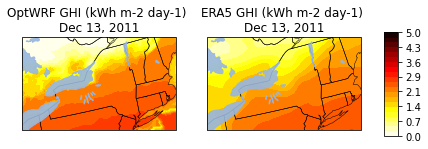

In [11]:
plots.compare_wrf_era5_plot('ghi', wrfdata_subset, eradata, hourly=False, save_fig=False)

In [12]:
# plots.wrf_errorandfitness_plot(wrfdata_subset, save_fig=False, wrf_dir=wrfdir, era_dir=eradir,
#                              fig_path='./', verbose=False, fitness_short_title='WRF CONUS Model Fitness',
#                              ghi_error_short_title='WRF CONUS GHI Error\n(kWh m-2 day-1)',
#                              wpd_error_short_title='WRF CONUS WPD Error\n(kWh m-2 day-1)')